In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
if not (project_root / 'src').exists():
    print(f"Ostrzeżenie: Nie znaleziono katalogu 'src' w {project_root}")
    
print(f"Dodano do ścieżki: {project_root}")


Dodano do ścieżki: /Users/michaliwaniuk/fromscratch-transformer-classifier


In [ ]:
from src.textclf_transformer.tokenizer.wordpiece_tokenizer_wrapper import WordPieceTokenizerWrapper
tok = WordPieceTokenizerWrapper()
tok.load(tokenizer_dir="src/textclf_transformer/tokenizer/BERT_original")
import torch

In [3]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd

ds = load_dataset('ccdv/arxiv-classification')

merged = concatenate_datasets([ds["test"], ds["train"], ds['validation']])
df = pd.DataFrame(merged)

In [4]:
df.head()

,text,label
0,arXiv:1403.4622v5 [math.GR] 15 Feb 2018\n\nCOM...,4
1,SUBMITTED TO IEEE TRANSACTIONS ON MEDICAL IMAG...,1
2,1\n\nImpact of Node Speed on Throughput of\nEn...,7
3,Resolvability on Continuous Alphabets\nMatthia...,7
4,Quantized Innovations Bayesian Filtering\nChun...,3


<Axes: >

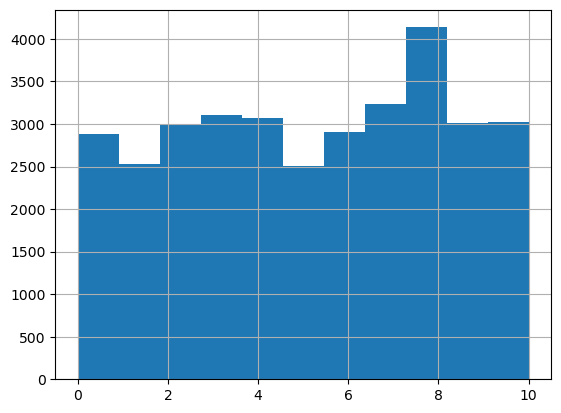

In [5]:
import pandas as pd

df['label'].hist(bins=11)

In [6]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df["label"],
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,          # połowa z 10% = 5%
    random_state=42,
    stratify=temp_df["label"],
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 26710 | Val: 3339 | Test: 3339


In [7]:
tok = WordPieceTokenizerWrapper()
path = Path("../../src/textclf_transformer/tokenizer/BERT_original")
tok.load(tokenizer_dir=path)

In [8]:

tokens_val = tok.encode_pandas(val_df, 'text',
                                max_length=16384,
                                label_col='label')
tokens_test = tok.encode_pandas(test_df, 'text',
                                 max_length=16384,
                                 label_col='label')

In [9]:
save_dir = Path("../../data/tokenized")
save_dir.mkdir(parents=True, exist_ok=True)

torch.save(tokens_val, save_dir / "arxiv_val.pt")
torch.save(tokens_test, save_dir / "arxiv_test.pt")

In [13]:
sample = list(train_df['text'])

In [17]:
label = list(train_df['label'])

In [22]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import TensorDataset, ConcatDataset


p1 = sample[:10000]
l1 = label[:10000]
p2 = sample[10000:20000]
l2 = label[10000:20000]
p3 = sample[20000:]
l3 = label[20000:]

encoded1 = tok.encode(p1, max_length=16384, labels=l1)
encoded2 = tok.encode(p2, max_length=16384, labels=l2)
encoded3 = tok.encode(p3, max_length=16384, labels=l3)



[INFO] input is treated as a list of input texts
[INFO] input is treated as a list of input texts
[INFO] input is treated as a list of input texts


In [27]:

concat = ConcatDataset([encoded1, encoded2, encoded3])

input_ids_list = []
attention_mask_list = []
labels_list = []

for ds in concat.datasets:
    ids, mask, label = ds.tensors
    input_ids_list.append(ids)
    attention_mask_list.append(mask)
    labels_list.append(label)
    

input_ids = torch.cat(input_ids_list, dim=0)
attention_mask = torch.cat(attention_mask_list, dim=0)
labels = torch.cat(labels_list, dim=0)
encoded = TensorDataset(input_ids, attention_mask, labels)

In [28]:
len(encoded)

26710

In [29]:
from pathlib import Path
import torch
save_dir = Path("../../data/tokenized")
save_dir.mkdir(parents=True, exist_ok=True)

torch.save(encoded, save_dir / "arxiv_train.pt")